In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2

from math import sqrt
sns.set()

In [4]:
raw_csv = pd.read_csv('Index2018.csv')
df_copy = raw_csv.copy()

In [5]:
df_copy['date'] = pd.to_datetime(df_copy['date'],dayfirst=True)

In [7]:
df_copy.set_index('date',inplace=True)

In [8]:
df_copy = df_copy.asfreq('b')

In [9]:
df_copy = df_copy.fillna(method='ffill')

In [10]:
df_copy.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [11]:
### Analyzing FTSE column as market_value(price)

df_copy['market_value'] = df_copy['ftse']

In [12]:
df_copy.drop(['spx','dax','ftse','nikkei'],inplace=True,axis=1)

In [13]:
df_copy.head()

,market_value
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


### 80-20 split

In [14]:
size = int(len(df_copy)*0.8)
df = df_copy.iloc[:size]
df_test = df_copy.iloc[size:]

### LLR test

In [15]:
def llr_test(model_1,model_2,df=1):
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,df).round(3)
    return p
    

### Creating Returns

In [16]:
df['returns']=df['market_value'].pct_change(1).mul(100)

<ipython-input-16-51bce0380152>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns']=df['market_value'].pct_change(1).mul(100)


In [17]:
df.head()

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


### ARMA(1,1)

In [20]:
model_ret_ar_1_ma_1 = ARMA(df.returns[1:],order=(1,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Mon, 18 Jan 2021   AIC                          15841.000
Time:                        11:02:23   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
### we see that only constant is not sig different from 0
## auto-reg coeff is postive (0.7649) while the moving average one is negative

## coeff of above 75 percent signifies there is a positive tendency between past and present value i.e, returs move in
## in trend of consecutive postive or negative value ,, this translates to periods of persistence increse or decreses 
## when translated to prices

In [22]:
## the negative MA coeff are slighly harder to interpret
## it suggest the we should be moving away from past period values reather than trying to use them as target
# for calibration

## these past error term ensures we dont get a "fool in the shower " type of error i.e we want to prevent our target
## from moving before we have accounted for them

In [23]:
## since ARMA(1,1) is an extension of simple AR and MA model we should run log-likelihood test to detrmine if it is a 
## better predictors

In [24]:
model_ret_ar_1 = ARMA(df.returns[1:],order=(1,0))
model_ret_ma_1 = ARMA(df.returns[1:],order=(0,1))

In [25]:
print('\n ARMA vs AR', llr_test(model_ret_ar_1,model_ret_ar_1_ma_1))
print('\n ARMA vs MA',llr_test(model_ret_ma_1, model_ret_ar_1_ma_1))


 ARMA vs AR 0.0

 ARMA vs MA 0.0


In [26]:
## since the p-value for both test end up becoming 0, this suggest that using past values in conjuction
## with past errors results in much better estimators

## our past estimator perform better as predictors than actual past value
## past estimator include both past values and past errors

## this is a bold statement ot make::: but if it is true

## ARMA model ought  to perform well when forcasting values into the future

### Higher-LAG ARMA model

In [ ]:
## acf and pacf graph gave very good idea of appropraite number of lags for MA and AR model.. let's have a quick glance


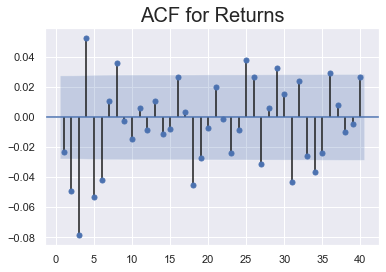

In [27]:
sgt.plot_acf(df['returns'][1:],zero=False, lags=40) # MA MODEL req 8 coeff
plt.title("ACF for Returns",size=20)
plt.show()

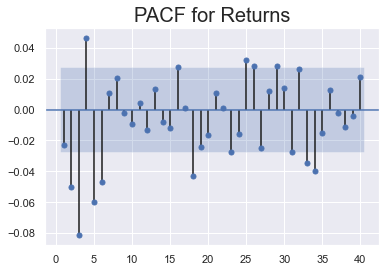

In [29]:
sgt.plot_pacf(df['returns'][1:],zero=False, lags=40) # AR req 6 coefficients
plt.title("PACF for Returns",size=20)
plt.show()

In [32]:
# suggest ARMA required (6,8) but this would result in complicated model where most of the coeff are not significat

## disadvantages of fitting such a complex model:
## 1 many of the coeff would proably cancel each other out
## 2 slow process

In [31]:
model_ret_ar_6_ma_8 = ARMA(df.returns[1:],order=(6,3))
results_models_ret_ar_6_ma_8 = model_ret_ar_6_ma_8.fit()
results_models_ret_ar_6_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 3)   Log Likelihood               -7884.833
Method:                       css-mle   S.D. of innovations              1.164
Date:                Mon, 18 Jan 2021   AIC                          15791.666
Time:                        11:56:12   BIC                          15863.399
Sample:                    01-10-1994   HQIC                         15816.803
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.012      1.539      0.124      -0.005       0.043
ar.L1.returns     1.1610      0.154      7.559      0.000       0.860       1.462
ar.L2.returns    -0.7653      0.198     -3.875      0.000      -1.152      -0.378
ar.L3.returns     0.4540      0.216      2.099      0.036       0.030       0.878
ar.L4.returns     0.1187      0.028      4.173      0.000       0.063       0.174
ar.L5.returns    -0.1457      0.031     -4.637      0.000      -0.207      -0.084
ar.L6.returns     0.0978      0.018      5.429      0.000       0.062       0.133
ma.L1.returns    -1.1854      0.153     -7.749      0.000      -1.485      -0.886
ma.L2.returns     0.7439      0.200      3.725      0.000       0.352       1.135
ma.L3.returns    -0.4989      0.226     -2.207      0.027      -0.942      -0.056
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0566           -0.0000j            1.0566           -0.0000
AR.2            0.0487           -1.2795j            1.2805           -0.2439
AR.3            0.0487           +1.2795j            1.2805            0.2439
AR.4           -1.8609           -0.0000j            1.8609           -0.5000
AR.5            1.0985           -1.4019j            1.7810           -0.1442
AR.6            1.0985           +1.4019j            1.7810            0.1442
MA.1            1.0485           -0.0000j            1.0485           -0.0000
MA.2            0.2214           -1.3649j            1.3827           -0.2244
MA.3            0.2214           +1.3649j            1.3827            0.2244
-----------------------------------------------------------------------------
"""

In [33]:
## so let us choose model with order(3,3)

In [35]:
model_ret_ar_3_ma_3 = ARMA(df.returns[1:],order=(3,3))
result_model_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
result_model_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Mon, 18 Jan 2021   AIC                          15803.030
Time:                        11:58:45   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     -3.389      0.001      -0.464      -0.124
ar.L3.returns     0.4459      0.138      3.225      0.001       0.175       0.717
ma.L1.returns     0.1707      0.099      1.726      0.084      -0.023       0.365
ma.L2.returns     0.2277      0.084      2.701      0.007       0.062       0.393
ma.L3.returns    -0.5432      0.127     -4.270      0.000      -0.793      -0.294
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5168           -1.0283j            1.1508           -0.3241
AR.2           -0.5168           +1.0283j            1.1508            0.3241
AR.3            1.6932           -0.0000j            1.6932           -0.0000
MA.1           -0.5286           -0.9835j            1.1166           -0.3285
MA.2           -0.5286           +0.9835j            1.1166            0.3285
MA.3            1.4764           -0.0000j            1.4764           -0.0000
-----------------------------------------------------------------------------
"""

In [39]:
## we can noite than first lag moving average compnont is 0.084 >0.05 is not signifiacntly diff from zero
## same with first lag ar component : 0.068>0.05

## this suggest that it may be irrelevant so a lower lag model would be a better use

In [36]:
## let's use LLR test to check if the compex model is a better fit than its simpler counterpart

In [38]:
print('LLR test',llr_test(model_ret_ar_1_ma_1,model_ret_ar_3_ma_3,df=4)) #(3+3-(1+1))

LLR test 0.0


In [41]:
## suggest that arma_3_3 makes better estimation than ARMA 1_1

## SO IF ARMA(1,1) is not the best fit (optimal model) we expect the best fit to be somewhere between [ARMA(1,1);ARMA(3,3)]
## SO we can lower the ar order or. MA order or both

In [42]:
# we still want a complicated modelso we begin with the model that consists of 5 total order (ar+ma)

In [43]:
## let us try arma(3,2) and arma(2,3) model next:

### ARMA(3,2)

In [44]:
model_ret_ar_3_ma_2 = ARMA(df.returns[1:],order=(3,2))
result_model_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
result_model_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Mon, 18 Jan 2021   AIC                          15805.495
Time:                        12:17:31   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     -3.670      0.000      -0.780      -0.237
ar.L3.returns    -0.1141      0.015     -7.655      0.000      -0.143      -0.085
ma.L1.returns     0.6568      0.087      7.536      0.000       0.486       0.828
ma.L2.returns     0.4474      0.141      3.175      0.001       0.171       0.724
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4929           -1.5100j            1.5885           -0.3002
AR.2           -0.4929           +1.5100j            1.5885            0.3002
AR.3           -3.4749           -0.0000j            3.4749           -0.5000
MA.1           -0.7340           -1.3025j            1.4951           -0.3317
MA.2           -0.7340           +1.3025j            1.4951            0.3317
-----------------------------------------------------------------------------
"""

In [ ]:
# ALL coeff apart from const are sig diff than 0 even at 1 percent sig level 
## howerve the constat being 0 does not bother us when we model returns beecause retuns in an efficient market should
##  be close to 0 anyway
## thus, none of the p-valeus for this model seems troublesome

## also, we can see that as the lags increse the absoulye value of the AR and MA model decreases -- this suppots
## the idea that the further back in time we go ,, the less relevant the values and error becomes 

## but this does not neceserily hold true for every model but a trend makes our model seem realistic 

## positive MA values suggest calibration efforts 

### ARMA(2,3)

In [45]:
model_ret_ar_2_ma_3 = ARMA(df.returns[1:],order=(2,3))
result_model_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
result_model_ret_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Mon, 18 Jan 2021   AIC                          15805.174
Time:                        12:18:01   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     -2.172      0.030      -0.796      -0.041
ma.L1.returns     0.5378      0.090      6.000      0.000       0.362       0.714
ma.L2.returns     0.3540      0.195      1.818      0.069      -0.028       0.736
ma.L3.returns    -0.1158      0.016     -7.369      0.000      -0.147      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6694           -1.3930j            1.5455           -0.3213
AR.2           -0.6694           +1.3930j            1.5455            0.3213
MA.1           -0.7270           -1.1772j            1.3836           -0.3381
MA.2           -0.7270           +1.1772j            1.3836            0.3381
MA.3            4.5096           -0.0000j            4.5096           -0.0000
-----------------------------------------------------------------------------
"""

In [46]:
## as with arma(3,3) moving average coeff for second lag is not sig diff than 0, so we should avoid using this model

In [47]:
## no use of LLR since, both arma3,2 and arma2,3 are simpler model--but still lets see the resut and interpret it

In [52]:
llr_test(model_ret_ar_2_ma_3,model_ret_ar_3_ma_3)

0.042

In [54]:
# the diff is significant at 5% level, which suggest we should opt for arma(3,3) isted of arma(2,3) one if we had to 
# choose only between these 2

In [55]:
llr_test(model_ret_ar_3_ma_2,model_ret_ar_3_ma_3)

0.035

### ARMA(3,1)

In [68]:
model_ret_ar_3_ma_1 = ARMA(df.returns[1:],order=(3,1))
result_model_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
result_model_ret_ar_3_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 1)   Log Likelihood               -7899.072
Method:                       css-mle   S.D. of innovations              1.167
Date:                Mon, 18 Jan 2021   AIC                          15810.144
Time:                        12:50:19   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.298      0.194      -0.010       0.047
ar.L1.returns    -0.5077      0.088     -5.769      0.000      -0.680      -0.335
ar.L2.returns    -0.0638      0.016     -4.023      0.000      -0.095      -0.033
ar.L3.returns    -0.1102      0.014     -7.850      0.000      -0.138      -0.083
ma.L1.returns     0.4839      0.088      5.500      0.000       0.311       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5095           -0.0000j            1.5095           -0.5000
AR.2            0.4653           -2.4076j            2.4521           -0.2196
AR.3            0.4653           +2.4076j            2.4521            0.2196
MA.1           -2.0668           +0.0000j            2.0668            0.5000
-----------------------------------------------------------------------------
"""

In [73]:
## all the coeff apeart from the const are significanlty diff than 0 

## same trend as arma 3,2 --> where all the MA coeff have positive coeff and all AR coeff has negative coeff
## this makes sense from financial point of view

In [74]:
llr_test(model_ret_ar_3_ma_1,model_ret_ar_3_ma_2,df=1)

0.01

In [75]:
# thus we can say that the more complicated model is the better approximation 

### ARMA(1,3)

In [71]:
model_ret_ar_1_ma_3 = ARMA(df.returns[1:],order=(1,3))
result_model_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
result_model_ret_ar_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 3)   Log Likelihood               -7896.838
Method:                       css-mle   S.D. of innovations              1.167
Date:                Mon, 18 Jan 2021   AIC                          15805.676
Time:                        12:51:23   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.332      0.183      -0.009       0.047
ar.L1.returns    -0.4699      0.096     -4.901      0.000      -0.658      -0.282
ma.L1.returns     0.4474      0.095      4.691      0.000       0.260       0.634
ma.L2.returns    -0.0637      0.015     -4.113      0.000      -0.094      -0.033
ma.L3.returns    -0.1182      0.014     -8.200      0.000      -0.146      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1282           +0.0000j            2.1282            0.5000
MA.1           -1.4882           -1.1206j            1.8629           -0.3973
MA.2           -1.4882           +1.1206j            1.8629            0.3973
MA.3            2.4376           -0.0000j            2.4376           -0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
## all coeff are significant ,, thus could be better approx 

In [80]:
## we cannot use LLR test because ARMA(1,3) is not nested inside ARMA(3,2) -- llr test becomes void
## hence we should manually compare them using LL value and AIC value
## samaller AIC and bigger Log LIKELIHOOD is preferred for the model to be better

In [81]:
### let us compare them manually!!

In [93]:
print('-------------------     AIC     -----------  LLvalue')
print()
print('ARMA(3,2)\t',result_model_ret_ar_3_ma_2.aic,result_model_ret_ar_3_ma_2.llf)
print('ARMA(1,3)\t',result_model_ret_ar_1_ma_3.aic, result_model_ret_ar_1_ma_3.llf)

-------------------     AIC     -----------  LLvalue

ARMA(3,2)	 15805.494917029213 -7895.7474585146065
ARMA(1,3)	 15805.675787505857 -7896.837893752929


In [90]:
## when compared manually, ARMA(3,2) seems better than ARMA(1,3) AND outperfroms its simple counterpart

## thus even ARMA(1,3) yielded sig coeff, it was still not the best option

In [72]:
llr_test(model_ret_ar_3_ma_1,model_ret_ar_3_ma_3,df=2)

0.004

### ARMA(2,2)

In [57]:
model_ret_ar_2_ma_2 = ARMA(df.returns[1:],order=(2,2))
result_model_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
result_model_ret_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 2)   Log Likelihood               -7913.223
Method:                       css-mle   S.D. of innovations              1.170
Date:                Mon, 18 Jan 2021   AIC                          15838.446
Time:                        12:45:28   BIC                          15877.573
Sample:                    01-10-1994   HQIC                         15852.156
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.394      0.163      -0.008       0.045
ar.L1.returns     0.7820      0.238      3.284      0.001       0.315       1.249
ar.L2.returns    -0.1563      0.177     -0.884      0.377      -0.503       0.190
ma.L1.returns    -0.8105      0.239     -3.388      0.001      -1.279      -0.342
ma.L2.returns     0.1177      0.187      0.628      0.530      -0.250       0.485
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5017           -0.3737j            2.5295           -0.0236
AR.2            2.5017           +0.3737j            2.5295            0.0236
MA.1            1.6107           +0.0000j            1.6107            0.0000
MA.2            5.2741           +0.0000j            5.2741            0.0000
-----------------------------------------------------------------------------
"""

In [79]:
## two of its parameter coeff are not significant,
## both non sig coeff are associated with the second lag wich also happens to be the last one
## which suggest that the simpler model ARMA(2,1) or ARMA(1,2) would be better approximation/ outperfrom
## the compelex one ARMA(2,2) 

## suggest us to avoid arma(2,2) at any cost

In [76]:
llr_test(model_ret_ar_2_ma_2,model_ret_ar_3_ma_2,df=1)

0.0

In [77]:
## says arma(3,2) is better than 2,2:()

### ARMA(1,2)

In [59]:
model_ret_ar_1_ma_2 = ARMA(df.returns[1:],order=(1,2))
result_model_ret_ar_1_ma_2 = model_ret_ar_1_ma_2.fit()
result_model_ret_ar_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 2)   Log Likelihood               -7913.670
Method:                       css-mle   S.D. of innovations              1.171
Date:                Mon, 18 Jan 2021   AIC                          15837.341
Time:                        12:46:01   BIC                          15869.947
Sample:                    01-10-1994   HQIC                         15848.766
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.410      0.158      -0.007       0.045
ar.L1.returns     0.6169      0.100      6.191      0.000       0.422       0.812
ma.L1.returns    -0.6471      0.100     -6.496      0.000      -0.842      -0.452
ma.L2.returns    -0.0422      0.017     -2.545      0.011      -0.075      -0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6210           +0.0000j            1.6210            0.0000
MA.1            1.4150           +0.0000j            1.4150            0.0000
MA.2          -16.7597           +0.0000j           16.7597            0.5000
-----------------------------------------------------------------------------
"""

In [67]:
llr_test(model_ret_ar_1_ma_2, model_ret_ar_3_ma_3,df=3)

0.0

In [60]:
## consider this later

### ARMA(2,1)

In [61]:
model_ret_ar_2_ma_1 = ARMA(df.returns[1:],order=(2,1))
result_model_ret_ar_2_ma_1 = model_ret_ar_2_ma_1.fit()
result_model_ret_ar_2_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 1)   Log Likelihood               -7913.456
Method:                       css-mle   S.D. of innovations              1.171
Date:                Mon, 18 Jan 2021   AIC                          15836.913
Time:                        12:46:39   BIC                          15869.519
Sample:                    01-10-1994   HQIC                         15848.338
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.405      0.160      -0.007       0.045
ar.L1.returns     0.6541      0.093      7.068      0.000       0.473       0.835
ar.L2.returns    -0.0433      0.017     -2.593      0.010      -0.076      -0.011
ma.L1.returns    -0.6829      0.092     -7.431      0.000      -0.863      -0.503
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7262           +0.0000j            1.7262            0.0000
AR.2           13.3733           +0.0000j           13.3733            0.0000
MA.1            1.4643           +0.0000j            1.4643            0.0000
-----------------------------------------------------------------------------
"""

In [66]:
llr_test(model_ret_ar_2_ma_1,model_ret_ar_3_ma_3,df=3)

0.0

In [62]:
## CONSIDER THIS LATER

In [95]:
## after goiing through all the models the best models seems to be ARMA(3,2)
## 1. HAS all significant coefficients 
## 2. outpredicts all less complex alternatives 

In [ ]:
## start with over-parameterized model and find a better and simpler option

In [97]:
## TO be absoutely certain that it analyze the data well, let us see its residuals

## Analyzing the residual of the ARMA(3,2)

### Residuals for Returns

In [101]:
df['res_ret_ar_3_ma_2']=result_model_ret_ar_3_ma_2.resid[1:]

<ipython-input-101-7d9f8fd0b5e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_ar_3_ma_2']=result_model_ret_ar_3_ma_2.resid[1:]


In [102]:
## plotting the result of the residuals

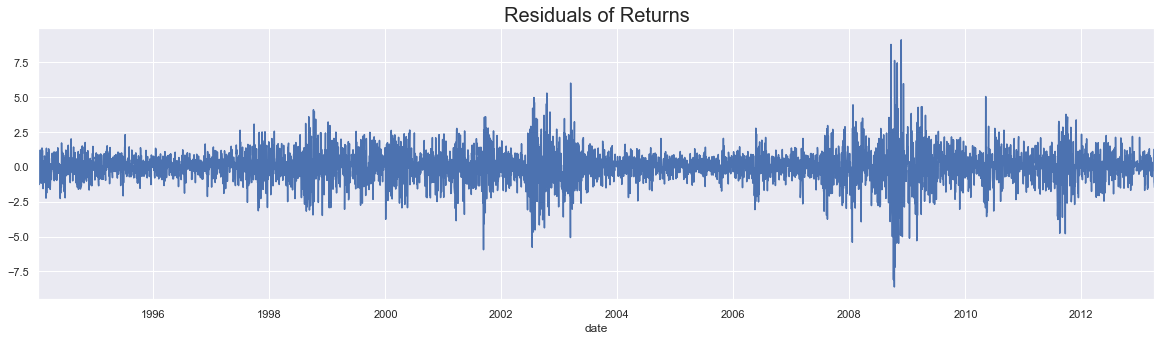

In [103]:
df['res_ret_ar_3_ma_2'].plot(figsize=(20,5))
plt.title('Residuals of Returns',size=20)
plt.show()

In [104]:
## similaer result as plot for residuals of MA and AR model
## thus volatility in returns might not be fully comprehendable if we use only ARMA models

In [105]:
## to make sure that the residuals are random ,, let us plot ACF

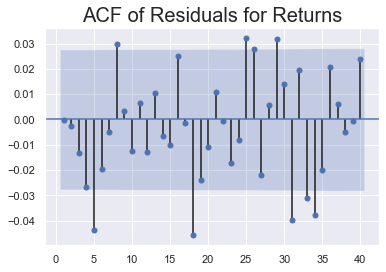

In [108]:
sgt.plot_acf(df['res_ret_ar_3_ma_2'][2:],lags=40,zero=False)
plt.title('ACF of Residuals for Returns',size=20)
plt.show()

In [113]:
## we can see more signifiacnt lags than ma and ar model
## since the 5th lag was incorporated in MA oly and AR only model-- so it made sence for its error term to be zero
## (look residual plot for MA and AR only model)
## therefore accounting for either return or residual 5 periods ago could improve our prediction

## thus we should start with ARMA(5,5) model and go through the models which have either AR order of 5 or MA order of 5

## find all models with all coeff significant 
## then  run LLR test on nested ones 
## comapre LLR and AIC for the others

### Reevaluation Model Selection

In [114]:
model_ret_ar_5_ma_5 = ARMA(df['returns'][1:],order=(5,5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
results_ret_ar_5_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 5)   Log Likelihood               -7882.160
Method:                       css-mle   S.D. of innovations              1.163
Date:                Mon, 18 Jan 2021   AIC                          15788.321
Time:                        13:58:38   BIC                          15866.575
Sample:                    01-10-1994   HQIC                         15815.742
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.402      0.161      -0.008       0.045
ar.L1.returns    -0.0684      0.140     -0.490      0.624      -0.342       0.205
ar.L2.returns    -0.6722      0.146     -4.603      0.000      -0.958      -0.386
ar.L3.returns    -0.1152      0.141     -0.817      0.414      -0.392       0.161
ar.L4.returns     0.1779      0.129      1.381      0.167      -0.075       0.430
ar.L5.returns     0.1215      0.107      1.132      0.258      -0.089       0.332
ma.L1.returns     0.0443      0.138      0.322      0.748      -0.226       0.314
ma.L2.returns     0.6223      0.144      4.321      0.000       0.340       0.905
ma.L3.returns     0.0107      0.136      0.079      0.937      -0.256       0.277
ma.L4.returns    -0.1753      0.122     -1.436      0.151      -0.415       0.064
ma.L5.returns    -0.2240      0.104     -2.148      0.032      -0.428      -0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0870           -1.0364j            1.0401           -0.2367
AR.2            0.0870           +1.0364j            1.0401            0.2367
AR.3            1.7715           -0.0000j            1.7715           -0.0000
AR.4           -1.7050           -1.1784j            2.0726           -0.4038
AR.5           -1.7050           +1.1784j            2.0726            0.4038
MA.1            0.1033           -1.0434j            1.0485           -0.2343
MA.2            0.1033           +1.0434j            1.0485            0.2343
MA.3            1.4855           -0.0000j            1.4855           -0.0000
MA.4           -1.2373           -1.0965j            1.6533           -0.3846
MA.5           -1.2373           +1.0965j            1.6533            0.3846
-----------------------------------------------------------------------------
"""

In [115]:
## we can see all but 3 of its coeff were significant hence taking both retuens and residuals 5 periods ago is redundant 
## and we should only focus on one of the 2

In [116]:
## let us try fitting ARMA(1,5)...ARMA(4,5) and ARMA(5,1)....ARMA(5,4) and see their summary table

In [117]:
## out of all only ARMA(1,5) and ARMA(5,1) yielded significant result 

## to test out of these two which one is better we cannot use LLR test, because both has the same dof

### ARMA(1,5)

In [118]:
model_ret_ar_1_ma_5 = ARMA(df['returns'][1:],order=(1,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
results_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 5)   Log Likelihood               -7890.973
Method:                       css-mle   S.D. of innovations              1.165
Date:                Mon, 18 Jan 2021   AIC                          15797.947
Time:                        14:14:36   BIC                          15850.116
Sample:                    01-10-1994   HQIC                         15816.228
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.419      0.156      -0.007       0.045
ar.L1.returns     0.3285      0.152      2.159      0.031       0.030       0.627
ma.L1.returns    -0.3534      0.152     -2.332      0.020      -0.650      -0.056
ma.L2.returns    -0.0404      0.015     -2.624      0.009      -0.071      -0.010
ma.L3.returns    -0.0679      0.017     -4.022      0.000      -0.101      -0.035
ma.L4.returns     0.0742      0.020      3.771      0.000       0.036       0.113
ma.L5.returns    -0.0683      0.015     -4.660      0.000      -0.097      -0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0442           +0.0000j            3.0442            0.0000
MA.1           -1.1897           -1.1548j            1.6580           -0.3774
MA.2           -1.1897           +1.1548j            1.6580            0.3774
MA.3            1.5041           -0.0000j            1.5041           -0.0000
MA.4            0.9809           -1.6057j            1.8815           -0.1627
MA.5            0.9809           +1.6057j            1.8815            0.1627
-----------------------------------------------------------------------------
"""

### ARMA(5,1)

In [119]:
model_ret_ar_5_ma_1 = ARMA(df['returns'][1:],order=(5,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
results_ret_ar_5_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 1)   Log Likelihood               -7889.311
Method:                       css-mle   S.D. of innovations              1.165
Date:                Mon, 18 Jan 2021   AIC                          15794.623
Time:                        14:15:29   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.407      0.159      -0.007       0.045
ar.L1.returns     0.3440      0.131      2.624      0.009       0.087       0.601
ar.L2.returns    -0.0458      0.015     -3.005      0.003      -0.076      -0.016
ar.L3.returns    -0.0652      0.016     -4.010      0.000      -0.097      -0.033
ar.L4.returns     0.0741      0.018      4.068      0.000       0.038       0.110
ar.L5.returns    -0.0813      0.014     -5.688      0.000      -0.109      -0.053
ma.L1.returns    -0.3673      0.131     -2.801      0.005      -0.624      -0.110
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6158           -0.0000j            1.6158           -0.5000
AR.2            1.3793           -0.8614j            1.6261           -0.0888
AR.3            1.3793           +0.8614j            1.6261            0.0888
AR.4           -0.1156           -1.6929j            1.6968           -0.2608
AR.5           -0.1156           +1.6929j            1.6968            0.2608
MA.1            2.7223           +0.0000j            2.7223            0.0000
-----------------------------------------------------------------------------
"""

In [120]:
## LET US MANUALLY examine their log likelihood (LL) and AIC value

In [124]:
print("                 LL ---------------- AIC")
print()
print("ARMA(1,5)",results_ret_ar_1_ma_5.llf,results_ret_ar_1_ma_5.aic)
print()
print("ARMA(5,1)",results_ret_ar_5_ma_1.llf,results_ret_ar_5_ma_1.aic)

                 LL ---------------- AIC

ARMA(1,5) -7890.9734602099115 15797.946920419823

ARMA(5,1) -7889.311282945884 15794.622565891768


In [125]:
## ARMA(5,1) has smaller AIC and larger LL value,, thus preferred model than ARMA(1,5)

## LET US compare this with the original choice of our best model ARMA(3,2)

In [130]:
print("                 LL ---------------- AIC")
print()
print("ARMA(3,2)",result_model_ret_ar_3_ma_2.llf,result_model_ret_ar_3_ma_2.aic)
print()
print("ARMA(5,1)",results_ret_ar_5_ma_1.llf,results_ret_ar_5_ma_1.aic)

                 LL ---------------- AIC

ARMA(3,2) -7895.7474585146065 15805.494917029213

ARMA(5,1) -7889.311282945884 15794.622565891768


In [131]:
## ARMA(5,1) has smaller AIC value and larger Log-likelihood value,, thus outperfroms the ARMA(3,2)
## ARMA(3,2) might have been too simplistic for the task

### Residual for the New Model ARMA(5,1)

In [132]:
## we can make the mistake of starting off with a model whose order is lower than the optimal one because unlike
## MA and AR model, ARMA has no ACF and PACF to suggest optimum number of lags needed.

## thus it is crucial to examine the residual for finding the best approximation of lags

In [135]:
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

<ipython-input-135-2575ffa4495d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid


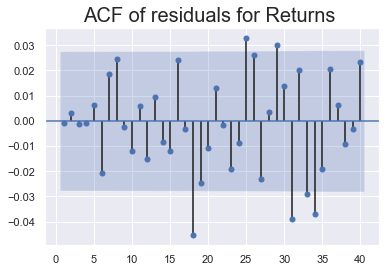

In [141]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:],lags=40,zero=False)
plt.title('ACF of residuals for Returns ', size=20)
plt.show()

In [143]:
# now the 5th lag is significant and also the 8th lag,, nor any other lag before 18th lag is insignificant  

# if we want our model to resemble the dataset more closely , we could include even more lags into our model
## however, this will predispose the model to faliure when facing unfamiliar data

## inclusing so many lags will help us know with confidence that how this dataset moves rather than understand how the
## actual market returns fluctuate 
## the effect of returns and errors tends to diminish over time--the further back in time we go over time,, the less
## relevant the values are in predicting the future

## since more than 10 of the first laga are not-significant ,, we can say that the residuals are pretty much random
## which is what we were trying to achieve 

### Let us Examine how ARMA model handles non-statinary data like prices

In [144]:
## the AR and MA model fail at prediciting the non-stationary data on their own

In [145]:
## before we fit any over-parameterized model let us plot acf and pacf plot for prices

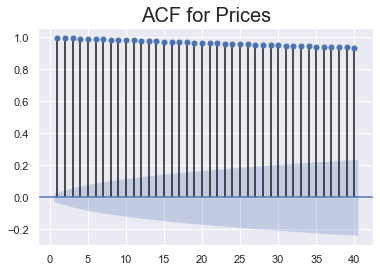

In [147]:
sgt.plot_acf(df.market_value,lags=40,zero=False)
plt.title('ACF for Prices',size=20)
plt.show()

In [149]:
# all the acf coefficients are significant as well as 6 of the first 7 PACF ones are significant 
## ACF suggest using infinitely many MA components -- unrealistic 

## an infite lag MA model(with certian resitrctions ) is equivalent to simple AR model-- thus as long as we include
## AR components we should be able to describe the data well by using a finite number of total lags 

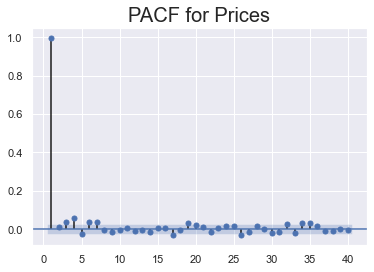

In [148]:
sgt.plot_pacf(df.market_value,lags=40,zero=False)
plt.title('PACF for Prices',size=20)
plt.show()

In [150]:
## let us start with simple ARMA model and examine its residual

In [151]:
model_ar_1_ma_1 = ARMA(df.market_value,order=(1,1))
result_ar_1_ma_1 = model_ar_1_ma_1.fit()
result_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 1)   Log Likelihood              -27621.789
Method:                       css-mle   S.D. of innovations             59.248
Date:                Mon, 18 Jan 2021   AIC                          55251.579
Time:                        14:50:12   BIC                          55277.664
Sample:                    01-07-1994   HQIC                         55260.719
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6410    496.785     10.245      0.000    4115.961    6063.321
ar.L1.market_value     0.9985      0.001   1323.195      0.000       0.997       1.000
ma.L1.market_value    -0.0190      0.015     -1.274      0.203      -0.048       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
MA.1           52.5192           +0.0000j           52.5192            0.0000
-----------------------------------------------------------------------------
"""

In [152]:
# AR and constatn coeff is significant but p-value for ma compenet is not significant 
# thus the simple model is not the best fit

In [153]:
## let us examine the residual before choosing our over-parameterized model

In [154]:
df['res_ar_1_ma_1']= result_ar_1_ma_1.resid

<ipython-input-154-904690a48a01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ar_1_ma_1']= result_ar_1_ma_1.resid


In [158]:
df.res_ar_1_ma_1[0]

-1643.660958249889

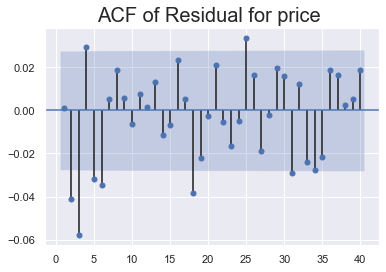

In [159]:
sgt.plot_acf(df.res_ar_1_ma_1,lags=40,zero=False)
plt.title('ACF of Residual for price ',size=20)
plt.show()

In [161]:
# 5 of the first 6 lags are significant so we must amend this-- by accounting for upto that much lags in our model 

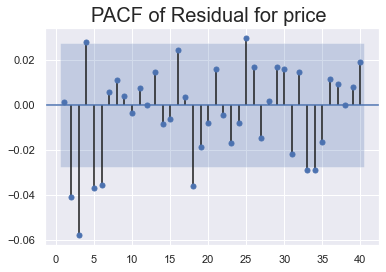

In [160]:
sgt.plot_pacf(df.res_ar_1_ma_1,lags=40,zero=False)
plt.title('PACF of Residual for price ',size=20)
plt.show()

In [162]:
## let us fit ARMA(6,6)

### ARMA(6,6)

In [180]:
model_ar_6_ma_6 = ARMA(df.market_value,order=(6,6))
result_ar_6_6 = model_ar_6_ma_6.fit(start_ar_lags=11)
result_ar_6_6.summary()

### generates an error: 
"""The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params."""
## there are solutions:
# 1. transforming data to returns (price->retuens)
# 2. choosing a different order (not useful we are intereseted in coeff for 6,6 )
## 3. setting the initial parameters  -> start_ar_lags of fit method 
## value we pass should be gretaer than the AR order of model(6)

## if method fails to compile, we gradually increse the initial lag until we get our summazrized table

## thus try 7,8,9......11.. until the mehthod ran without any error


'The computed initial AR coefficients are not stationary\nYou should induce stationarity, choose a different model order, or you can\npass your own start_params.'

In [ ]:
## we see that some of the coeff are not signifiant ,, thus we should lower the total number of lags and conduct a
## trail and error approach 
## we hould try all models which contains either 6 MA lags or 6 AR lags
## going thrgh all the model,, the one that giave all sig result were ARMA(5,6) ARMA(6,1)

In [179]:
model_ar_6_ma_1 = ARMA(df.market_value,order=(6,1))
result_ar_6_1 = model_ar_6_ma_1.fit(start_ar_lags=7)
result_ar_6_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 1)   Log Likelihood              -27594.195
Method:                       css-mle   S.D. of innovations             58.923
Date:                Mon, 18 Jan 2021   AIC                          55206.389
Time:                        15:09:56   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6421    586.532      8.678      0.000    3940.061    6239.223
ar.L1.market_value     1.3921      0.058     23.930      0.000       1.278       1.506
ar.L2.market_value    -0.4369      0.059     -7.400      0.000      -0.553      -0.321
ar.L3.market_value    -0.0101      0.025     -0.409      0.683      -0.059       0.038
ar.L4.market_value     0.1126      0.025      4.527      0.000       0.064       0.161
ar.L5.market_value    -0.1158      0.025     -4.717      0.000      -0.164      -0.068
ar.L6.market_value     0.0573      0.014      4.067      0.000       0.030       0.085
ma.L1.market_value    -0.4126      0.060     -6.925      0.000      -0.529      -0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2           -1.7608           -0.0000j            1.7608           -0.5000
AR.3           -0.0803           -1.8407j            1.8424           -0.2569
AR.4           -0.0803           +1.8407j            1.8424            0.2569
AR.5            1.4694           -0.8691j            1.7072           -0.0850
AR.6            1.4694           +0.8691j            1.7072            0.0850
MA.1            2.4234           +0.0000j            2.4234            0.0000
-----------------------------------------------------------------------------
"""

In [181]:
model_ar_5_ma_6 = ARMA(df.market_value,order=(5,6))
result_ar_5_6 = model_ar_5_ma_6.fit(start_ar_lags=7)
result_ar_5_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 6)   Log Likelihood              -27587.863
Method:                       css-mle   S.D. of innovations             58.849
Date:                Mon, 18 Jan 2021   AIC                          55201.726
Time:                        15:10:36   BIC                          55286.504
Sample:                    01-07-1994   HQIC                         55231.433
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6475    580.797      8.763      0.000    3951.306    6227.988
ar.L1.market_value     1.3582      0.178      7.643      0.000       1.010       1.707
ar.L2.market_value    -1.1287      0.237     -4.754      0.000      -1.594      -0.663
ar.L3.market_value     0.9145      0.229      3.995      0.000       0.466       1.363
ar.L4.market_value     0.0161      0.204      0.079      0.937      -0.384       0.416
ar.L5.market_value    -0.1613      0.119     -1.351      0.177      -0.395       0.073
ma.L1.market_value    -0.3794      0.178     -2.129      0.033      -0.729      -0.030
ma.L2.market_value     0.7294      0.125      5.826      0.000       0.484       0.975
ma.L3.market_value    -0.2196      0.153     -1.434      0.152      -0.520       0.080
ma.L4.market_value    -0.1387      0.114     -1.215      0.224      -0.362       0.085
ma.L5.market_value    -0.0879      0.017     -5.326      0.000      -0.120      -0.056
ma.L6.market_value     0.0265      0.024      1.127      0.260      -0.020       0.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0917           -1.0418j            1.0458           -0.2360
AR.2            0.0917           +1.0418j            1.0458            0.2360
AR.3            1.0010           -0.0000j            1.0010           -0.0000
AR.4            1.8985           -0.0000j            1.8985           -0.0000
AR.5           -2.9832           -0.0000j            2.9832           -0.5000
MA.1            0.1071           -1.0487j            1.0542           -0.2338
MA.2            0.1071           +1.0487j            1.0542            0.2338
MA.3           -1.5354           -1.5156j            2.1575           -0.3760
MA.4           -1.5354           +1.5156j            2.1575            0.3760
MA.5            1.5921           -0.0000j            1.5921           -0.0000
MA.6            4.5810           -0.0000j            4.5810           -0.0000
-----------------------------------------------------------------------------
"""

In [184]:
## manually comparing these result suing LLR and AIC


In [187]:
print('               LLF            AIC')
print(' ---------------------------------------')
print('ARMA(5,6)',result_ar_5_6.llf, result_ar_5_6.aic)
print()
print('ARMA(6,1)',result_ar_6_1.llf,result_ar_6_1.aic)

               LLF            AIC
 ---------------------------------------
ARMA(5,6) -27587.862949394115 55201.72589878823

ARMA(6,1) -27594.194571013326 55206.38914202665


In [188]:
## ARMA(5,6) has lower AIC and higher LLF , thus better model than AMRA(6,1) and thus the preferred model

In [189]:
## let us now extract the error and comment on their ACF

In [190]:
df['res_ar_5_ma_6'] = result_ar_5_6.resid

<ipython-input-190-61e70eb1181f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ar_5_ma_6'] = result_ar_5_6.resid


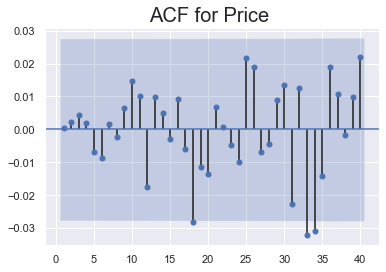

In [193]:
sgt.plot_acf(df.res_ar_5_ma_6, lags=40, zero=False )
plt.title('ACF for Price ',size=20)
plt.show()

In [195]:
## out of 40 lags--- only 3 are sig diff than 0
## some are positive and some are negative,, and there seems to be no signifiacnt pattern wahtsoever
## significant upto 18 lags  --- thus error seems to be random,, resembled white noise
## so our solution of model seems very good right now

In [196]:
## We said that ARMA performed poorly when it comes to non-stationary data 
## to verrify if this is true,, let us compare ARMA for return(stationary) and ARMA for price (non-staionary)

### ARMA for Returns VS ARMA for prices

In [197]:
## let us compare LL and AIC value

In [201]:
print(' ---------                LLF                 AIC')
print('------------------------------------------------------')
print('ARMA(5,6) for Prices',result_ar_5_6.llf, result_ar_5_6.aic)
print('ARMA(5,1) for returns', results_ret_ar_5_ma_1.llf, results_ret_ar_5_ma_1.aic)

 ---------                LLF                 AIC
------------------------------------------------------
ARMA(5,6) for Prices -27587.862949394115 55201.72589878823
ARMA(5,1) for returns -7889.311282945884 15794.622565891768


In [203]:
## even though we can model prices using ARMA model they perform much worse compared to their ability to estimate
## stationary data

## obivously because there is something missing


## ARMA(5,1) for retuens has much less AIC  and much higher LLF compared to ARMA(5,6) for prices
## thus we can conclude that ARMA performs poorly on non-stationary data(price in this case)  comapred to stationary (return) in this case